In [1]:
#시도목록, 시군목록, 지자체 영역코드목록, 아파트 코드목록 구하는 함수, 웹크롤링에 필요한 페이지수 구하는 함수
#getSidoSggList()
#getCityCodeDf(key, sidoListData, sggListData)
#getAptDf(key, cityCodeDfData)
#setPageRowNum(countData)


#지자체별, 아파트별 음식물쓰레기 버린양 구하는 함수
#getCityDateDf(key, cityCodeDfData)
#getCityAptDateDf(key, cityAptDfData, startIndex)

#아파트 배출량, 지자체 배출량 그래프 그리는 함수
#DrawCityDateGraph(sidoNameData, sggNameData, start, end, cityDateDfData)
#DrawCityAptDateGraph(sidoNameData, sggNameData, aptNameData, cityAptDateDfData)

#메인함수 변수 정리
"""
mainSidoList 
시도목록, list

mainSggList 
시군구목록, list

mainCityCodeDf 
지자체 영역코드목록, DataFrame(시도이름, 시군구이름, 지자체영역코드)

mainCityAptDf 
아파트 코드목록, DataFrame (시도이름, 시군구이름, 지자체영역코드, 아파트이름, 아파트코드)

mainCityDateDf 
지자체별 배출량 목록, DataFrame(시도이름, 시군구이름, 총 버린양. 총 버린 횟수, yymmdd형식의 날짜)

mainCityAptDateDf 
아파트별 배출량 목록, DataFrame(시도이름, 시군구이름, 아파트이름,총 버린양. 총 버린 횟수, yymmdd형식의 날짜)

"""



'\nmainSidoList \n시도목록, list\n\nmainSggList \n시군구목록, list\n\nmainCityCodeDf \n지자체 영역코드목록, DataFrame(시도이름, 시군구이름, 지자체영역코드)\n\nmainCityAptDf \n아파트 코드목록, DataFrame (시도이름, 시군구이름, 지자체영역코드, 아파트이름, 아파트코드)\n\nmainCityDateDf \n지자체별 배출량 목록, DataFrame(시도이름, 시군구이름, 총 버린양. 총 버린 횟수, yymmdd형식의 날짜)\n\nmainCityAptDateDf \n아파트별 배출량 목록, DataFrame(시도이름, 시군구이름, 아파트이름,총 버린양. 총 버린 횟수, yymmdd형식의 날짜)\n\n'

In [2]:
import urllib.request
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bs4


#api_key: 서비스 이용을 위한 인증키 
apiKey = "0RypH9CCjx4DM7IrIy70H0qR1LPSQY3U%2B5joMKgwtUXvHbQ2i57p%2B6f00zNDCDF683D%2BYL7j2IU6LGotJniPhQ%3D%3D"



def getSidoSggList():    
    """
    시도목록, 시군구목록을 구하는 함수이다.
    
    입력파라미터는 없다.
    
    [시도이름1, 시도이름1, ..., 시도이름2, 시도이름2,...],
    [시군구이름1_1, 시군구이름1_2, ..., 시군구이름2_1, 시군구이름2_2, ...]의 형식을 반환한다
    
    return sidoList, sggList
    sidoList, sggList는 둘다 list타입이다.
    sidoList, sggList의 요소들은 string타입이다.
    sidoList -> 시도목록, sggList -> 시군구목록
    """
    
    sidoList = []
    sggList = []
    
    url = "http://openapi.1365.go.kr/openapi/service/rest/CodeInquiryService/getAreaCodeInquiryList?numOfRows=230"
    html = urllib.request.urlopen(url)
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    
    
    items = bs_obj.findAll("item")
    for item in items:
        sidoName = item.find("sidonm").text
        sggName = item.find("gugunnm").text
        sidoList.append(sidoName)
        sggList.append(sggName)
    

    return sidoList, sggList



def getCityCodeDf(key, sidoListData, sggListData):
    """
    지자체영역코드목록을 구하는 함수이다.
    
    입력파라미터는 key, sidoListData, sggListData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    sidoListData, sggListData는 지자체검색에 쓰인다.
    sidoListData, sggListData는 둘다 list타입이고, 각각의 요소들은 string타입이다.
    
    DataFrame(columns = ['SidoName', 'SggName', 'CityCode')의 형식을 반환한다.
    
    return cityCodeDf
    cityCodeDf는 DataFrame타입이다.
    cityCodeDf안에 있는 모든 요소는 string타입이다.
    cityCodeDf -> (시도이름, 시군구이름, 지자체영역코드)가 들어있다.
    """
    
    cityCodeDf = pd.DataFrame()
    
    for i in range(len(sidoListData)):
        sidoName = sidoListData[i]
        tempSidoName = quote(sidoName)
        sggName = sggListData[i]
        tempSggName = quote(sggName)
        
        
        
        #요청메세지 형식
        #url_format에 들어가는 포매팅 변수 api_key = key, citySidoName = tempSidoName, citySggName = tempSggName
        url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getCityList?ServiceKey={api_key}&type=xml&page=1&rowNum=50&citySidoName={citySidoName}&citySggName={citySggName}".format(api_key = key, citySidoName = tempSidoName, citySggName = tempSggName)
        try:
            html = urllib.request.urlopen(url_format)
        except (urllib.error.HTTPError, urllib.error.URLError) as e:
            rowDf = getCityCodeDfForError(key, sidoListData, sggListData, i)
            cityCodeDf = cityCodeDf.append(rowDf, ignore_index = True)
            continue
        
        
        bs_obj = bs4.BeautifulSoup(html, "html.parser")
        li = bs_obj.find("list")
        if li is None:
            continue
        else:    
            cityCode = li.find('citycode').text
            rowDf = pd.DataFrame({'SidoName':[sidoName],
                                  'SggName':[sggName], 'CityCode':[cityCode]})
            cityCodeDf = cityCodeDf.append(rowDf, ignore_index = True)
            
        
    return cityCodeDf







def getCityCodeDfForError(key, sidoListData, sggListData, index):
    """
    지자체영역코드목록을 구하는 함수이다.
    
    입력파라미터는 key, sidoListData, sggListData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    sidoListData, sggListData는 지자체검색에 쓰인다.
    sidoListData, sggListData는 둘다 list타입이고, 각각의 요소들은 string타입이다.
    
    DataFrame(columns = ['SidoName', 'SggName', 'CityCode')의 형식을 반환한다.
    
    return cityCodeDf
    cityCodeDf는 DataFrame타입이다.
    cityCodeDf안에 있는 모든 요소는 string타입이다.
    cityCodeDf -> (시도이름, 시군구이름, 지자체영역코드)가 들어있다.
    """
    rowDf = pd.DataFrame()
    
    cityCodeDf = pd.DataFrame()
    
    sidoName = sidoListData[index]
    tempSidoName = quote(sidoName)
    sggName = sggListData[index]
    tempSggName = quote(sggName)
        
        
        
    #요청메세지 형식
    #url_format에 들어가는 포매팅 변수 api_key = key, citySidoName = tempSidoName, citySggName = tempSggName
    url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getCityList?ServiceKey={api_key}&type=xml&page=1&rowNum=50&citySidoName={citySidoName}&citySggName={citySggName}".format(api_key = key, citySidoName = tempSidoName, citySggName = tempSggName)
    try:
        html = urllib.request.urlopen(url_format)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        rowDf = getCityCodeDf(key, sidoListData, sggListData, index)
        return rowDf
    
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    li = bs_obj.find("list")
    if li is None:
        return rowDf
    else:    
        cityCode = li.find('citycode').text
        rowDf = pd.DataFrame({'SidoName':[sidoName],
                              'SggName':[sggName], 'CityCode':[cityCode]})
    return rowDf




def getAptDf(key, cityCodeDfData):
    """
    아파트이름목록과 아파트코드목록을 구하는 함수이다.
    
    입력파라미터는 key, cityCodeDfData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityCodeDfData는 아파트이름, 아파트코드검색에 쓰인다.
    cityCodeDfData는 (시도이름, 시군구이름, 지자체영역코드)의 형식으로 되어있다.
    data들은 모두 string이다.
    
    DataFrame(columns = ['SidoName', 'SggName', 'CityCode', 'AptName', 'AptCode'])의 형식을 반환한다.
    
    return aptDf
    aptDf는 DataFrame타입이다.
    aptDf안에 있는 모든 요소는 string타입이다.
    aptDf -> (시도이름, 시군구이름, 지자체영역코드, 아파트이름, 아파트코드)가 들어있다.
    """
    aptDf = pd.DataFrame()
    

    
    for i in range(len(cityCodeDfData)):
        stateOk = 0;
        
        sidoName = cityCodeDfData.loc[i, 'SidoName']
        sggName = cityCodeDfData.loc[i, 'SggName']
        cityCode = cityCodeDfData.loc[i, 'CityCode']
        
        
        #요청메세지 형식
        #url_format에 들어가는 포매팅 변수 api_key = key, city = cityCode
        url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getAptlist?ServiceKey={api_key}&type=xml&page=1&rowNum=1&cityCode={city}".format(api_key = key, city = cityCode)
        try:
            html = urllib.request.urlopen(url_format)
        except (urllib.error.HTTPError, urllib.error.URLError) as e:
            pageNum, rowNum = getAptDfForErrorForFirst(key, cityCodeDfData, i)
            stateOk = 1;
        
        if stateOk == 0:
            bs_obj = bs4.BeautifulSoup(html, "html.parser")
            count = bs_obj.find("count").text
            #pageNum, RowNum 설정
            pageNum, rowNum = setPageRowNum(count)
        
        
        for j in range(1, int(pageNum)):
            #요청메세지 형식
            #url_format에 들어가는 포매팅 변수 api_key = key, page = j, row = rowNum, city = cityCode
            url = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getAptlist?ServiceKey={api_key}&type=xml&page={page}&rowNum={row}&cityCode={city}".format(api_key = key, page = j, row = rowNum, city = cityCode)
            try:
                html = urllib.request.urlopen(url)
            except (urllib.error.HTTPError, urllib.error.URLError) as e:
                tempDf = getAptDfForErrorSecond(key, cityCodeDfData, i, j, rowNum)
                aptDf = aptDf.append(tempDf, ignore_index = True)
                continue
                
            bs_obj = bs4.BeautifulSoup(html, "html.parser")
            lis = bs_obj.findAll("list")
            
            for li in lis:
                if li.find('aptmanage').text == '0':
                    continue
                else:
                    aptCode = li.find("aptcode").text
                    aptName = li.find("aptname").text
                    rowDf = pd.DataFrame({'SidoName':[sidoName],
                                          'SggName':[sggName], 'CityCode':[cityCode],'AptName':[aptName],'AptCode':[aptCode]})
                    aptDf = aptDf.append(rowDf, ignore_index = True)
                        
    return aptDf




def getAptDfForErrorForFirst(key, cityCodeDfData, index):
    """
    getAptDf에서 첫번째 URL을 가져올 때 에러가 난 경우 이 함수로 들어와서 해당 URL의 데이터를 얻을 때까지 재귀호출을 한다.
    
    입력파라미터는 key, cityCodeDfData, index이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityCodeDfData는 아파트이름, 아파트코드검색에 쓰인다.
    cityCodeDfData는 (시도이름, 시군구이름, 지자체영역코드)의 형식으로 되어있다.
    index는 cityCodeDfData에서 몇번째 행인지를 알려준다.
    data들은 모두 string이다.
    
    (pageNum, rowNum)의 형태를 반환한다. 둘 다 string이다.
    
    return pageNum, rowNum
    pageNum, rowNum
    두번째 url호출시 호출할 페이지가 몇개인지(pageNum), 호출한 페이지에 몇개의 행을 나타낼것인지(rowNum) 정하는 변수들이다.
    
    """
    aptDf = pd.DataFrame()
    
    sidoName = cityCodeDfData.loc[index, 'SidoName']
    sggName = cityCodeDfData.loc[index, 'SggName']
    cityCode = cityCodeDfData.loc[index, 'CityCode']
        
        
    #요청메세지 형식
    #url_format에 들어가는 포매팅 변수 api_key = key, city = cityCode
    url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getAptlist?ServiceKey={api_key}&type=xml&page=1&rowNum=1&cityCode={city}".format(api_key = key, city = cityCode)
        
    try:
        html = urllib.request.urlopen(url_format)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        pageNum, rowNum = getAptDfForErrorForFirst(key, cityCodeDfData, index)
        return pageNum, rowNum
            
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    count = bs_obj.find("count").text
    #pageNum, RowNum 설정
    pageNum, rowNum = setPageRowNum(count)
    
    return pageNum, rowNum


def getAptDfForErrorSecond(key, cityCodeDfData, index, pageIndex, rowNumData):
    """
    getCityAptDateDf에서 두번째 URL에러가 난 경우 이 함수로 들어와서 해당 URL의 데이터를 얻을 때까지 재귀호출을 한다.
    
    입력파라미터는 key, cityCodeDfData, pageIndex, rowNumData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityCodeDfData는 아파트이름, 아파트코드검색에 쓰인다.
    cityCodeDfData는 (시도이름, 시군구이름, 지자체영역코드)의 형식으로 되어있다.
    pageIndex는 몇번째 페이지에서 error가 난건지 알고 그 페이지의 url을 다시 호출하기 위한 값이다.
    rowNumData는 호출하는 페이지당 몇개의 행을 나타내야하는지 표시하기 위한 값이다.
    data들은 모두 string이다.
    
    DataFrame(columns = ['SidoName', 'SggName', 'CityCode', 'AptName', 'AptCode'])의 형식을 반환한다.
    
    return tempAptDf
    tempAptDf DataFrame타입이다.
    tempAptDf 있는 모든 요소는 string타입이다.
    tempAptDf -> (시도이름, 시군구이름, 지자체영역코드, 아파트이름, 아파트코드)가 들어있다.
    """
    tempAptDf = pd.DataFrame()
    
    sidoName = cityCodeDfData.loc[index, 'SidoName']
    sggName = cityCodeDfData.loc[index, 'SggName']
    cityCode = cityCodeDfData.loc[index, 'CityCode']
    
    #요청메세지 형식
    #url_format에 들어가는 포매팅 변수 api_key = key, page = i, row = rowNum, city = cityCode
    url = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getAptlist?ServiceKey={api_key}&type=xml&page={page}&rowNum={row}&cityCode={city}".format(api_key = key, page = pageIndex, row = rowNumData, city = cityCode)
    try:
        html = urllib.request.urlopen(url)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        tempAptDf = getAptDfForErrorSecond(key, cityCodeDfData, index, pageIndex, rowNumData)
        return tempAptDf
    
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    lis = bs_obj.findAll("list")
    
    for li in lis:
        if li.find('aptmanage').text == '0':
            continue
        else:
            aptCode = li.find("aptcode").text
            aptName = li.find("aptname").text
            rowDf = pd.DataFrame({'SidoName':[sidoName],
                                  'SggName':[sggName], 'CityCode':[cityCode],'AptName':[aptName],'AptCode':[aptCode]})
            tempAptDf = tempAptDf.append(rowDf, ignore_index = True)  
            
    return tempAptDf




def setPageRowNum(countData):
    """
    크롤링하는 과정에서 데이터의 종류마다 데이터의 개수가 달라서 page와 row의 개수를 정해야한다.
    이때 필요한 page와 row의 개수를 구하는 함수이다.
    row는 100으로 고정했다.
    
    입력파라미터는 countData이다. 
    countData는 파싱하려는 데이터의 총개수를 의미하고, string타입이다
    
    return pageNumber, rowNumber
    pageNumber, rowNumber는 string타입이다.
    pageNumber -> 페이지번호, rowNumber -> 페이지마다 출력할 데이터 수
    """
    
    pageNumber = str((int(countData) // 100) + 2)
    rowNumber = '100'
    
    return pageNumber, rowNumber

In [3]:
#getCityAptDf에서 aptName도 구하는 것 추가하고, getCityDateDf와 getCityAptDf 둘다에서 Time을 추가하고
#year, month, date를 지우기
def getCityDateDf(key, cityCodeDfData, yearData, monthData):
    """
    원하는 년도와 달에 해당 지역이 배출한 음식물쓰레기양과 배출한 횟수를 구하는 함수이다.
    
    입력파라미터는 key,cityCodeDfData, yearData, monthData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityCodeDfData는 음식물쓰레기양과 배출한 횟수 검색을 위해 쓰인다.
    cityCodeDfData는 (시도이름, 시군구이름, 지자체영역코드)의 형식으로 되어있다.
    yearData는 찾고자 하는 년도이다.
    monthData는 찾고자 하는 달이다.
    data들은 모두 string이다.
    
    DataFrame(columns = ['SidoName', 'SggName', 'DisQuantityAvg', 'Time'])의 형식을 반환한다.
    
    return cityDateDf
    cityDateDf는 DataFrame타입이다.
    cityDateDf안에 있는 SidoName, SggName는 string타입이고, 나머지는 int타입이다.
    cityDateDf -> 지자체 배출량을 알기위한 데이터 목록(시도이름, 시군구이름, 배출량/배출횟수, 날짜)
    """
    cityDateDf = pd.DataFrame()
    for index in range(len(cityCodeDfData)):
        sidoName = cityCodeDfData.loc[index, 'SidoName']
        sggName = cityCodeDfData.loc[index, 'SggName']
        cityCode = cityCodeDfData.loc[index, 'CityCode']
        
        url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getCityDateList?ServiceKey={api_key}&type=xml&page=1&rowNum=31&disYear={disYear}&disMonth={disMonth}&cityCode={city}".format(api_key = key, disYear = yearData, disMonth = monthData, city = cityCode)
        try:
            html = urllib.request.urlopen(url_format)
        except urllib.error.HTTPError as e:
            tempDf = getCityDateDfForError(key, cityCodeDfData, yearData, monthData, index)
            cityDateDf = cityDateDf.append(tempDf, ignore_index = True)
            continue
        
        bs_obj = bs4.BeautifulSoup(html, "html.parser")
        lis = bs_obj.findAll('list')    
        
        for li in lis:
            if li is None:
                continue
            else:
                disQuantity = li.find('disquantity').text
                disCount = li.find('discount').text
                date = li.find('disdate').text
                time = int(yearData)*10000 + int(monthData)*100 + int(date)
                disQuantityAvg = int(disQuantity)/int(disCount)
                
                rowDf = pd.DataFrame({'SidoName':[sidoName], 'SggName':[sggName],
                                      'DisQuantityAvg':[disQuantityAvg], 'Time':[time]})
                cityDateDf = cityDateDf.append(rowDf, ignore_index = True)
                
    return cityDateDf



def getCityDateDfForError(key, cityCodeDfData, yearData, monthData, index):
    """
    getCityAptDateDf에서 URL에러가 난 경우 이 함수로 들어와서 해당 URL의 데이터를 얻을 때까지 재귀호출을 한다.
    
    입력파라미터는 key,cityCodeDfData, yearData, monthData이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityCodeDfData는 음식물쓰레기양과 배출한 횟수 검색을 위해 쓰인다.
    cityCodeDfData는 (시도이름, 시군구이름, 지자체영역코드)의 형식으로 되어있다.
    yearData는 찾고자 하는 년도이다.
    monthData는 찾고자 하는 달이다.
    data들은 모두 string이다.
   
    DataFrame(columns = ['SidoName', 'SggName', 'DisQuantityAvg', 'Time'])의 형식을 반환한다.
    
    return tempCityDateDf
    
    tempCityDateDf는 DataFrame타입이다.
    tempCityDateDf안에 있는 SidoName, SggName는 string타입이고, 나머지는 int타입이다.
    tempCityDateDf -> 지자체 배출량을 알기위한 데이터 목록(시도이름, 시군구이름, 배출량/배출횟수, 날짜)
    """
    tempCityDateDf = pd.DataFrame()
    
    sidoName = cityCodeDfData.loc[index, 'SidoName']
    sggName = cityCodeDfData.loc[index, 'SggName']
    cityCode = cityCodeDfData.loc[index, 'CityCode']
        
    url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getCityDateList?ServiceKey={api_key}&type=xml&page=1&rowNum=31&disYear={disYear}&disMonth={disMonth}&cityCode={city}".format(api_key = key, disYear = yearData, disMonth = monthData, city = cityCode)
    try:
        html = urllib.request.urlopen(url_format)
    except urllib.error.HTTPError as e:
        tempCityDateDf = getCityDateDfForError(key, cityCodeDfData, yearData, monthData, index)
        return tempCityDateDf
        
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    lis = bs_obj.findAll('list')    
    
    for li in lis:
        if li is None:
            continue
        else:
            disQuantity = li.find('disquantity').text
            disCount = li.find('discount').text
            date = li.find('disdate').text
            time = int(yearData)*10000 + int(monthData)*100 + int(date)
            disQuantityAvg = int(disQuantity)/int(disCount)
            rowDf = pd.DataFrame({'SidoName':[sidoName], 'SggName':[sggName],
                                  'DisQuantityAvg':[disQuantityAvg], 'Time':[time]})
            tempCityDateDf = tempCityDateDf.append(rowDf, ignore_index = True)
            
    return tempCityDateDf






def getCityAptDateDf(key, cityAptDfData, year, month):
    """
    원하는 년도와 달의 해당 지역아파트가 배출한 음식물쓰레기양과 배출한 횟수를 구하는 함수이다.
    
    입력파라미터는 key,cityAptDfData, year, month이다.
    key는 공공데이터 api에 접근하기 위한 api_key값으로 string타입이다.
    cityAptDfData는 음식물쓰레기양과 배출한 횟수 검색을 위해 쓰인다.
    cityAptDfData는 (시도이름, 시군구이름, 지자체영역코드, 아파트이름, 아파트코드)의 형식으로 되어있다.
    year는 찾고자 하는 년도이다.
    month는 찾고자 하는 달이다.
    data들은 모두 string이다.
    
    cityAptDateDf, urlErrorList, listErrorList를 반환한다.
    

    return cityAptDateDf, urlErrorList, listErrorList
    cityAptDateDf는 DataFrame타입이다. DataFrame(columns = ['SidoName', 'SggName', 'AptName', DisQuantityAvg. 'Time'])의 형식을 반환한다..
    cityAptDateDf안에 있는 SidoName, SggName, AptName는 string타입이고 나머지는 int타입이다.
    cityAptDateDf -> 아파트 배출량을 알기위한 데이터 목록(시도이름, 시군구이름, 아파트이름, 배출량, 배출횟수)
    urlErrorList는 (year+month, sidoName, sggName, cityCode, aptCode, "url error")의 요소를 갖는 리스트이다. url을 열 때 생기는 에러의 목록을 관리한다.
    listErrorList는(year+month, sidoName, sggName, cityCode, aptCode, "li is None")의 요소를 갖는 리스트이다. url을 열였을 때 빈 url을 연 경우를 관리한다.
    """
    cityAptDateDf = pd.DataFrame()

    
    now = 0
    
    urlErrorList = []
    listErrorList = []
    cityAptDateDf = pd.DataFrame()


    
    #데모버전으로 생각해서 for문의 range의 값을 변경하여 수원시와 용인시의 아파트의 데이터만 구한다.
    #7511~7610 수원시 아파트    
    #7616~8161 용인시 아파트
    
    #목록전체 구하기
    #for index in range(len(cityAptDfData)):
    for index in range(7511, 7611):
        if index % 1000 == 0:
            now = now + 1
            print(year+month, now)
        sidoName = cityAptDfData.loc[index, 'SidoName']
        sggName = cityAptDfData.loc[index, 'SggName']
        cityCode = cityAptDfData.loc[index, 'CityCode']
        aptCode = cityAptDfData.loc[index, 'AptCode']
        
        url_format = "http://apis.data.go.kr/B552584/RfidFoodWasteService/getCityAptDateList?ServiceKey={api_key}&type=xml&page=1&rowNum=31&disYear={disYear}&disMonth={disMonth}&cityCode={city}&aptCode={apt}".format(api_key = key, disYear = year, disMonth = month, city = cityCode, apt = aptCode)
        try:
            html = urllib.request.urlopen(url_format)
        except (urllib.error.HTTPError, urllib.error.URLError) as e:
            rowList = [sidoName, sggName, cityCode, aptCode]
            urlErrorList.append((year+month, sidoName, sggName, cityCode, aptCode, "url error"))
            tempDf,tempUrlErrorList,tempListErrorList = getCityAptDateDfForError(url_format, rowList, [], [], year, month)
            
            urlErrorList.extend(tempUrlErrorList)
            listErrorList.extend(tempListErrorList)
            cityAptDateDf = cityAptDateDf.append(tempDf, ignore_index = True)
            continue
        
        bs_obj = bs4.BeautifulSoup(html, "html.parser")
        lis = bs_obj.findAll('list')
                
        for li in lis:
            if li is None:
                if (year+month, sidoName, sggName, cityCode, aptCode, "li is None") not in li:
                    listErrorList.append((year+month, sidoName, sggName, cityCode, aptCode, "li is None"))
                else:
                    continue
            else:
                disQuantity = li.find('disquantity').text
                disCount = li.find('discount').text
                date = li.find('disdate').text
                aptName = li.find('aptname').text
                time = str(int(year)*10000 + int(month)*100 + int(date))
                disQuantityAvg = str(int(disQuantity)/int(disCount))
                
                rowDf = pd.DataFrame({'SidoName':[sidoName], 'SggName':[sggName], 'AptName':[aptName],
                                      'DisQuantityAvg':[disQuantityAvg], 'Time':[time]})
                cityAptDateDf = cityAptDateDf.append(rowDf, ignore_index = True)
                
    yearMonth = year + month    
    #fileName = "mainCityAptDateDf{yearmonth}.csv".format(yearmonth = yearMonth)
    #cityAptDateDf.to_csv(fileName, mode = 'w')
    
    return cityAptDateDf, urlErrorList, listErrorList



def getCityAptDateDfForError(urlFormatData, rowListData,urlErrorListData, listErrorListData, year, month):
    """
    getCityAptDateDf에서 URL에러가 난 경우 이 함수로 들어와서 해당 URL의 데이터를 얻을 때까지 재귀호출을 한다.
    입력파라미터는 urlFormatData, rowListData,urlErrorListData, listErrorListData, year, month이다.
    urlFormatData는 데이터를 얻으려는 url정보이다.
    rowListData는 cityAptDateDf에 데이터를 추가하기위해 필요한 정보인 sidoName, sggName, cityCode, aptCode의 정보를 가지고 있다
    urlErrorListData는 url에러가 나는 경우 에러정보를 추가하기 위해 있는 에러리스티이다.
    listErrorListData
    year 찾으려는 년도이다. listErrorList에 정보를 추가하기 위해 필요하다.
    month 찾으려는 달이다. listErrorList에 정보를 추가하기 위해 필요하다.
    
    cityAptDateDf, urlErrorList, listErrorList을 반환한다.
    
    return cityAptDateDf, urlErrorList, listErrorList
    cityAptDateDf는 DataFrame타입이다. DataFrame(columns = ['SidoName', 'SggName', 'AptName', DisQuantityAvg. 'Time'])의 형식을 반환한다..
    cityAptDateDf안에 있는 SidoName, SggName, AptName는 string타입이고 나머지는 int타입이다.
    cityAptDateDf -> 아파트 배출량을 알기위한 데이터 목록(시도이름, 시군구이름, 아파트이름, 배출량, 배출횟수)
    urlErrorList는 (year+month, sidoName, sggName, cityCode, aptCode, "url error")의 요소를 갖는 리스트이다. url을 열 때 생기는 에러의 목록을 관리한다.
    listErrorList는(year+month, sidoName, sggName, cityCode, aptCode, "li is None")의 요소를 갖는 리스트이다. url을 열였을 때 빈 url을 연 경우를 관리한다.
    """
    
    rowList = rowListData
    url_format = urlFormatData
    sidoName = rowList[0]
    sggName = rowList[1]
    cityCode = rowList[2]
    aptCode = rowList[3]
    
    urlErrorList = []
    urlErrorList.extend(urlErrorListData)
    
    listErrorList = []
    
    cityAptDateDf = pd.DataFrame()
    
    try:
        html = urllib.request.urlopen(url_format)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        urlErrorList.append((year+month, sidoName, sggName, cityCode, aptCode, "url error"))
            
        cityAptDateDf, tempUrlErrorList, listErrorList = getCityAptDateDfForUrlError(url_format, rowList, urlErrorList, listErrorList,year, month)
        urlErrorList.extend(urlErrorList)
        return cityAptDateDf, urlErrorList, listErrorList

        
    bs_obj = bs4.BeautifulSoup(html, "html.parser")
    lis = bs_obj.findAll('list')
                
    for li in lis:
        if li is None:
            if (year+month, sidoName, sggName, cityCode, aptCode, "li is None") not in li:
                listErrorList.append((year+month, sidoName, sggName, cityCode, aptCode, "li is None"))
            else:
                continue
        else:
            disQuantity = li.find('disquantity').text
            disCount = li.find('discount').text
            date = li.find('disdate').text
            aptName = li.find('aptname').text
            time = str(int(year)*10000 + int(month)*100 + int(date))
            disQuantityAvg = str(int(disQuantity)/int(disCount))
                
            rowDf = pd.DataFrame({'SidoName':[sidoName], 'SggName':[sggName], 'AptName':[aptName],
                                  'DisQuantityAvg':[disQuantityAvg], 'Time':[time]})
            cityAptDateDf = cityAptDateDf.append(rowDf, ignore_index = True)
                
    
    return cityAptDateDf, urlErrorList, listErrorList



In [ ]:
#저장한 데이터 불러오기
mainCityCodeDf = pd.read_csv("mainCityCodeDf.csv")
mainCityAptDf = pd.read_csv("mainCityAptDf.csv")

In [ ]:

#데이터 구하기
mainSidoList, mainSggList = getSidoSggList()
mainCityCodeDf = getCityCodeDf(apiKey, mainSidoList, mainSggList)
mainCityAptDf = getAptDf(apiKey, mainCityCodeDf)


#데이터 저장하기
mainCityCodeDf.to_csv("mainCityCodeDf.csv",mode = 'w')
mainCityAptDf.to_csv('mainCityAptDf.csv', mode = 'w')



In [ ]:
mainCityDateDf = pd.DataFrame()

monthList = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
yearList = ['2018','2019']
for yearData in yearList:
    for monthData in monthList:
        if yearData == '2019' and monthData == '05':
            break;

        tempCityDateDf = getCityDateDf(apiKey, mainCityCodeDf, yearData, monthData)
        mainCityDateDf = mainCityDateDf.append(tempCityDateDf, ignore_index = True)

        
mainCityDateDf.to_csv("mainCityDateDf.csv", mode = 'w', index = False)

In [ ]:
#urlErrorList와 listErrorList를 저장하는 list이다.
mainErrorList = []

mainCityAptDateDf = pd.DataFrame()

monthList = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
yearList = ['2018','2019']
for yearData in yearList:
    for monthData in monthList:
        if yearData == '2019' and monthData == '05':
            break;
            
        tempErrorList = []
        tempCityAptDateDf, tempUrlErrorList,tempListErrorList = getCityAptDateDf(apiKey, mainCityAptDf, yearData, monthData)
        mainErrorList.append((yearData+monthData, tempUrlErrorList, tempListErrorList))
        mainCityAptDateDf = mainCityAptDateDf.append(tempCityAptDateDf, ignore_index = True)
        
mainCityAptDateDf.to_csv("mainSuwonCityDateDf.csv",mode = 'w', index = False)
#mainCityAptDateDf.to_csv("mainYongInCityDateDf.csv",mode = 'w', index = False)


In [4]:
def DrawCityDateGraph(sidoNameData, sggNameData, start, end, cityDateDfData):
    """
    지자체 배출량 그래프를 그리는 함수이다.
    입력파라미터는 sidoNameData, sggNameData, start, end이다.
    sidoNameData는 시도이름, sggNameData는 시군구이름으로 둘 다 string타입이다.
    start는 시작날짜, end는 마지막날짜로 둘 다 int타입이다.
    
    x축은 날짜, y축은 (일주일 동안 버린양/일주일 동안 버린횟수)이다. 
    
    return resultCityDf
    resultCityDf DataFrame타입이다.
    resultCityDf 있는 모든 요소는 int타입이다.
    resultCityDf -> 지자체별로 주별로 버리는 음식물쓰레기 데이터 목록(일주일동안 버리는 양, 주)
    """
    startYear = start // 10000
    startMonth = (start - startYear*10000) // 100
    startDate = (start - startYear*10000 - startMonth*100)
    
    endYear = end // 10000
    endMonth = (end - endYear*10000) // 100
    endDate = (end - endYear*10000 - endMonth*100)   

    tempResultDf = pd.DataFrame()
    resultCityDf = pd.DataFrame()
    tempDf = cityDateDfData
    tempDf = tempDf[tempDf.SidoName.str.contains(sidoNameData)]
    tempDf = tempDf[tempDf.SggName.str.contains(sggNameData)]
    
    tempDf.sort_values(by='Time')
    #tempDf = tempDf.reset_index(drop = True)

   
    for index in range(len(tempDf)):
        time = tempDf.iloc[index, 3]
        disQuantityAvg = tempDf.iloc[index, 2]
      
        if ( (time >= start) and (time <= end) ):
            rowDf = pd.DataFrame({"DisQuantityAvg":[disQuantityAvg], "Time": [time]})
            tempResultDf = tempResultDf.append(rowDf,ignore_index = True )
    
    
    disQuantityAvgForWeek = 0
    week = 1
    for index in range(len(tempResultDf)):
        disQuantityAvg = tempResultDf.loc[index, "DisQuantityAvg"]
        disQuantityAvgForWeek = disQuantityAvgForWeek + disQuantityAvg
        if index % 7 == 0:
            rowDf = pd.DataFrame({"DisQuantityForWeek":[disQuantityAvg/1000], "Week": [week]})
            resultCityDf = resultCityDf.append(rowDf,ignore_index = True )
            disQuantityAvgWeek = 0
            week = week + 1
        else:
            if index == len(resultCityDf)-1:
                rowDf = pd.DataFrame({"DisQuantityForWeek":[disQuantityAvg/1000], "Week": [week]})
                resultCityDf = resultCityDf.append(rowDf,ignore_index = True )


    
    resultCityDf.plot.line(x = "Week", y = "DisQuantityForWeek")
    plt.title("CityWaste")
    plt.ylabel("DisQuantityForWeek(kg)")
    print(sidoNameData, sggNameData)
    
    return resultCityDf
    
    

In [5]:
def DrawCityAptDateGraph(sidoNameData, sggNameData, aptNameData, start, end, cityAptDateDfData):
    """
    지자체 배출량 그래프를 그리는 함수이다.
    입력파라미터는 sidoNameData, sggNameData, start, end이다.
    sidoNameData는 시도이름, sggNameData는 시군구이름으로 둘 다 string타입이다.
    start는 시작날짜, end는 마지막날짜로 둘 다 int타입이다.
    
    x축은 날짜, y축은 일주일 동안 버린양이다. 
    
    return resultCityDf
    resultCityDf DataFrame타입이다.
    resultCityDf 있는 모든 요소는 int타입이다.
    resultCityDf -> 아파트별로 주별로 버리는 음식물쓰레기 데이터 목록(일주일동안 버리는 양, 주)
    """
    startYear = start // 10000
    startMonth = (start - startYear*10000) // 100
    startDate = (start - startYear*10000 - startMonth*100)
    
    endYear = end // 10000
    endMonth = (end - endYear*10000) // 100
    endDate = (end - endYear*10000 - endMonth*100)   

    tempResultDf = pd.DataFrame()
    resultCityDf = pd.DataFrame()
    tempDf = cityAptDateDfData
    
    tempDf = tempDf[tempDf.SidoName.str.contains(sidoNameData)]
    tempDf = tempDf[tempDf.SggName.str.contains(sggNameData)]
    #괄호가 들어가는 경우 안돼서 아래에 새로 구현
    #tempDf = tempDf[tempDf.AptName.str.contains(aptNameData)]

    resultDf = pd.DataFrame()
    #해당하는 아파트만 선정
    for i in range(len(tempDf)):
        if tempDf.iloc[i,2] == aptNameData:
            rowDf = pd.DataFrame({ "DisQuantityAvg":[tempDf.iloc[i,3]], "Time":[tempDf.iloc[i,4]]})
            resultDf = resultDf.append(rowDf, ignore_index = True)
    
    tempDf = resultDf
    
    
    tempDf.sort_values(by='Time')
    tempDf = tempDf.reset_index(drop = True)
    
    #해당하는 기간만 선정
    for index in range(len(tempDf)):
        time = tempDf.loc[index, "Time"]
        disQuantityAvg = tempDf.loc[index, "DisQuantityAvg"]
      
        if ( (time >= start) and (time <= end) ):
            rowDf = pd.DataFrame({"DisQuantityAvg":[disQuantityAvg], "Time": [time]})
            tempResultDf = tempResultDf.append(rowDf,ignore_index = True )
    
    
    
    disQuantityAvgForWeek = 0
    week = 1
    for index in range(len(tempResultDf)):
        disQuantityAvg = tempResultDf.loc[index, "DisQuantityAvg"]
        disQuantityAvgForWeek = disQuantityAvgForWeek + disQuantityAvg
        if index % 7 == 0:
            rowDf = pd.DataFrame({"DisQuantityForWeek":[disQuantityAvg/1000], "Week": [week]})
            resultCityDf = resultCityDf.append(rowDf,ignore_index = True )
            disQuantityAvgWeek = 0
            week = week + 1
        else:
            if index == len(resultCityDf)-1:
                rowDf = pd.DataFrame({"DisQuantityForWeek":[disQuantityAvg/1000], "Week": [week]})
                resultCityDf = resultCityDf.append(rowDf,ignore_index = True )


    
    resultCityDf.plot.line(x = "Week", y = "DisQuantityForWeek")
    plt.title("CityAptWaste")
    plt.ylabel("DisQuantityForWeek(kg)")
    print(sidoNameData, sggNameData, aptNameData)
    
    return resultCityDf

In [8]:
#저장한 데이터 불러오기
mainCityDateDf = pd.read_csv("mainCityDateDf.csv")
mainSuwonCityDateDf = pd.read_csv("mainSuwonCityDateDf.csv")
mainYonginCityDateDf = pd.read_csv("mainYonginCityDateDf.csv")


제주특별자치도 제주시


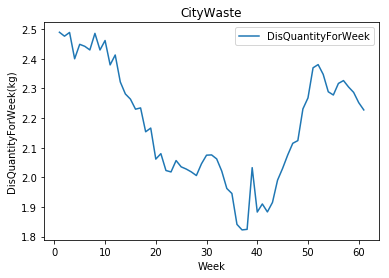

In [9]:
#지자체 배출량 그래프 그리기
mainResultCityDf = DrawCityDateGraph("제주특별자치도", '제주시', 20180101, 20190331, mainCityDateDf)
mainResultCityDf.to_csv("mainJejuCityDf20180101_20190331.csv", mode = 'w', index = False)

경기도 용인시 구갈한성2차(BM)


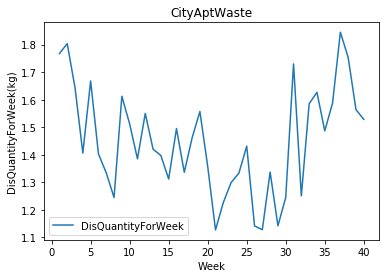

In [10]:
#아파트 배출량 그래프 그리고 결과 저장
mainResultCityAptDf = DrawCityAptDateGraph("경기도", '용인시', '구갈한성2차(BM)',20180301, 20190331, mainYonginCityDateDf)

mainResultCityDf.to_csv("mainYonginAptDf20180101_20190331.csv", mode = 'w', index = False)

경기도 수원시 정자-벽산블루밍


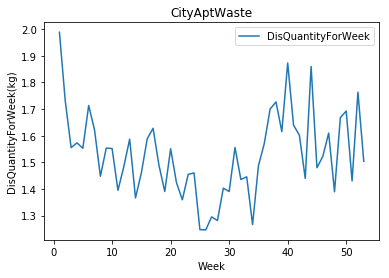

In [11]:
mainResultCityAptDf = DrawCityAptDateGraph("경기도", '수원시', '정자-벽산블루밍',20180301, 20190331, mainSuwonCityDateDf)

mainResultCityDf.to_csv("mainSuwonAptDf20180101_20190331.csv", mode = 'w', index = False)